In [50]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from sklearn.preprocessing import StandardScaler
# import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gpytorch
from scipy.linalg import solve
from gpytorch.kernels import RBFKernel,ScaleKernel,LinearKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from joblib import Parallel, delayed

In [51]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [52]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','cost'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

In [53]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 12000
TAU = 0.005
LR = 1e-4
nrow=20
ncol=20
# nA=8
# nS = 144
Lbd=0
Rbd=10
Ubd=10
Dbd=0
T=180
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
cost_threshold=0.3

input_dim = 2
hidden_dim = 32
latent_dim = 16
# safety_bound=0.3
sigma_noise=0.1
move_lb=0.6
move_ub=1.2
test_safe_para=0.7
# Get number of actions from gym action space
n_actions = 4
# Get the number of state observations
state=np.zeros(2)
n_observations = len(state)
num_episodes = 250
Method=1 
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)






In [66]:
def state_to_block(s):
    a=int(np.floor(s[0]/Rbd*nrow))
    b=int(np.floor(s[1]/Ubd*nrow))
    if a==nrow:
        a=int(a-1)
    if b==ncol:
        b=int(b-1)
    return int(a),int(b)

def select_action(state,steps_done):
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1),steps_done
    else:
        return torch.tensor([[np.random.choice(4, 1)[0]]], device=device, dtype=torch.long),steps_done# change
def select_result_action(state,result_steps_done):
    result_steps_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * result_steps_done / EPS_DECAY)
    result_steps_done += 1
    if True:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1), result_steps_done
    else:
        return torch.tensor([[np.random.choice(4, 1)[0]]], device=device, dtype=torch.long)# change

def cal_grid_center(point,divide_dist):
    return np.round(np.array(point)/divide_dist)*divide_dist


def test_safe_action(state,action,mean,cov):
    next_state=np.copy(state)
    dist=np.random.uniform(move_lb,move_ub,1)
    if action == LEFT:
        next_state[0] = max(state[0] - dist, Lbd)
    elif action == DOWN:
        next_state[1] = max(state[1] - dist, Dbd)
    elif action == RIGHT:
        next_state[0] = min(state[0] + dist, Rbd)
    elif action == UP:
        next_state[1] = min(state[1] + dist, Ubd)
    row,col=state_to_block(state)
    b=(mean[row,col]+test_safe_para*cov[row,col,row,col] <cost_threshold)
    return b


def select_safe_action(state,mean,cov,steps_safe_done):
    steps_safe_done
    
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_safe_done / EPS_DECAY)
    steps_safe_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1),steps_safe_done
    else:
        possible_action=np.ones(4)
        for i in range(4):
            if test_safe_action(state.numpy()[0],i,mean,cov)!=True:
                possible_action[i]=0
        if np.sum(possible_action)==0:
            with torch.no_grad():
                return policy_net(state).max(1).indices.view(1, 1),steps_safe_done
        else:
            a=np.random.choice(4,size=1,p=possible_action/np.sum(possible_action))[0]
            return torch.tensor([[a]], device=device, dtype=torch.long),steps_safe_done# change

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def cal_cost(s):
    c1=np.array([3,3])
    c2=np.array([7,7])
    d1=np.linalg.norm(s-c1)
    d2=np.linalg.norm(s-c2)
    return max(4-2*d1,4-2*d2,0)

def cal_reward(s):
    end=10*np.ones(2)
    dist=np.linalg.norm(s-end)
    if dist<1:
        return 10*(1-dist)
    else:
        return 0
def not_same_data(i_episode,epi_len,X_train,obs):
    for i in range(i_episode+1):
        for j in range(int(epi_len[i])):
            if np.linalg.norm(X_train[i,j]-obs)<1e-6:
                return False
    return True
def env_step(state,action,t):
    
    next_state=np.copy(state)
    dist=np.random.uniform(move_lb,move_ub,1)
    if action == LEFT:
        next_state[0] = max(state[0] - dist, Lbd)
    elif action == DOWN:
        next_state[1] = max(state[1] - dist, Dbd)
    elif action == RIGHT:
        next_state[0] = min(state[0] + dist, Rbd)
    elif action == UP:
        next_state[1] = min(state[1] + dist, Ubd)

    reward=cal_reward(state)
    cost=cal_cost(next_state)
    if next_state[0]==Rbd and next_state[1]==Ubd:
        truncated=True
    elif t>T:
        truncated=True
    else:  truncated=False

    return next_state,reward,cost,False,truncated
def result_route():
    steps_done=10000
    result_episode=np.zeros((T,7))
    state=np.zeros(2)
    # result_episode[0,0:2]=np.copy(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in range(T):
        action,steps_done = select_action(state,steps_done)
        #action = select_safe_action(state,model)
        observation, reward, cost, terminated, truncated = env_step(state.numpy()[0],action.numpy()[0][0],t) #change
        reward = torch.tensor([reward], device=device)
        cost=torch.tensor([cost], device=device)
        result_episode[t,0:2]=np.copy(state.numpy()[0])
        result_episode[t,2]=action.numpy()[0][0]
        result_episode[t,3:5]=np.copy(observation)
        result_episode[t,5]=reward
        result_episode[t,6]=cost
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    return result_episode

def result_safe_route(mean,cov):
    result_episode=np.zeros((T,7))
    state=np.zeros(2)
    steps_safe_done=10000
    # result_episode[0,0:2]=np.copy(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in range(T):
        action, steps_safe_done= select_safe_action(state,mean,cov,steps_safe_done)
        observation, reward, cost, terminated, truncated = env_step(state.numpy()[0],action.numpy()[0][0],t) #change
        result_episode[t,0:2]=np.copy(state.numpy()[0])
        result_episode[t,2]=action.numpy()[0][0]
        result_episode[t,3:5]=np.copy(observation)
        result_episode[t,5]=reward
        result_episode[t,6]=cost
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    return result_episode
def gauss_fit(mu_input,cov_input,data_block,n_visit_block):
    mu=np.copy(mu_input)
    cov=np.copy(cov_input)
    new_mu=np.zeros((nrow,ncol))
    new_cov=np.zeros((nrow,ncol,nrow,ncol))

    # for s in initial_gauss_set:
    #     visit_set[to_row_col(s)[0],to_row_col(s)[1]]=1
    for row in range(nrow):
        for col in range(ncol):
            if  n_visit_block[row,col]>0:
                y=np.copy(data_block[row,col])
                new_mu=mu+cov[:,:,row,col]/(cov[row,col,row,col]+sigma_noise)*(y-mu[row,col])
                new_mu[row,col]=np.copy(y)
                for j1 in range(nrow):
                    for k1 in range(ncol):
                        for j2 in range(nrow):
                            for k2 in range(ncol):
                                new_cov[j1,k1,j2,k2]=cov[j1,k1,j2,k2]-cov[j1,k1,row,col]*cov[j2,k2,row,col]/(cov[row,col,row,col]+sigma_noise)
                        #print(str(i)+','+str(j)+','+str(k)+':'+str(new_cov[j,k]-cov[j,k]))
                        #print(str(i)+','+str(j)+','+str(k)+':'+str(cov[j,s]*cov[s,k]/(cov[s,s]+sigma_noise)))
                # new_cov[:,s]=0
                # new_cov[s,:]=0
                mu=np.copy(new_mu)
                cov=np.copy(new_cov)

    return mu, cov

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    cost_batch = torch.cat(batch.cost)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [55]:
def one_rep():
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(10000)
    
    steps_done = 0
    steps_safe_done=0
    total_cost=np.zeros(num_episodes)

    # GPmodel = GaussianProcessNN(input_dim, hidden_dim, latent_dim)
    kernel = RBF(length_scale=5,length_scale_bounds=(1e-2, 1e6)) #+ WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    X_train=np.zeros((num_episodes,T,2))
    Y_train=np.zeros((num_episodes,T))
    epi_len=np.zeros(num_episodes)
    epi_violation=np.zeros(num_episodes)
    # scaler = StandardScaler()
    n_visit_block=np.zeros((num_episodes,nrow,ncol))
    data_block=np.zeros((num_episodes,nrow,ncol))
    mean_block=np.zeros((num_episodes+1,nrow,ncol))
    cov_block=np.zeros((num_episodes+1,nrow,ncol,nrow,ncol))
    mean_initial=np.zeros((nrow,ncol))
    for  i1 in range(nrow):
        for j1 in range(ncol):
            for  i2 in range(nrow):
                for j2 in range(ncol):
                    cov_block[0,i1,j1,i2,j2]=np.exp(-(i1-i2)**2/50-(j1-j2)**2/50)
    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state=np.zeros(2)
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        if i_episode==0:
            for t in range(T):
                if Method==1 and epi_violation[i_episode]>1.5:
                    break
                action ,steps_done= select_action(state,steps_done)
                observation, reward, cost, terminated, truncated = env_step(state.numpy()[0],action.numpy()[0][0],t) #change
                if cost>cost_threshold:
                    epi_violation[i_episode]+=1
                    total_cost[i_episode]+=cost
                reward = torch.tensor([reward-25*cost], device=device)
                cost=torch.tensor([cost], device=device)

                done = terminated or truncated
                if not_same_data(i_episode,epi_len,X_train,observation):
                    X_train[i_episode, int(epi_len[i_episode])]=np.copy(observation)
                    Y_train[i_episode, int(epi_len[i_episode])]=cost
                    epi_len[i_episode]=epi_len[i_episode]+1
                row,col=state_to_block(observation)
                data_block[i_episode,row,col]=data_block[i_episode,row,col]*n_visit_block[i_episode,row,col]+cost
                n_visit_block[i_episode,row,col]+=1
                data_block[i_episode,row,col]=data_block[i_episode,row,col]/n_visit_block[i_episode,row,col]
                
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                # Store the transition in memory
                memory.push(state, action, next_state, reward,cost)
                # Move to the next state
                state = next_state
                # Perform one step of the optimization (on the policy network)
                optimize_model()
                # Soft update of the target network's weights
                # theta′ ← τ theta + (1 −τ )theta′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)

                if done:
                    episode_durations.append(t + 1)
                    plot_durations()
                    break
            # X=np.copy(X_train[i_episode,0:int(epi_len[i_episode])])
            # Y=np.copy(Y_train[i_episode,0:int(epi_len[i_episode])])
            # X = scaler.fit_transform(X)
        else:
            for t in range(T):
                if Method==1 and epi_violation[i_episode]>1.5:
                    break
                if Method==0:
                    action,steps_done = select_action(state,steps_done)
                elif Method==1:
                    action ,steps_safe_done= select_safe_action(state,mean_block[i_episode],cov_block[i_episode],steps_safe_done)
                    # possible_action=np.ones(4)
                    # for i in range(4):
                    #     if test_safe_action(state.numpy()[0],i,gp)!=True:
                    #         possible_action[i]=0
                    # if np.sum(possible_action)==0:
                    #     with torch.no_grad():
                    #     action=policy_net(state).max(1).indices.view(1, 1)
                #     else:
                #         a=np.random.choice(4,size=1,p=possible_action/np.sum(possible_action))[0]
                #         action=torch.tensor([[a]], device=device, dtype=torch.long)# change
                observation, reward, cost, terminated, truncated = env_step(state.numpy()[0],action.numpy()[0][0],t) #change
                if cost>cost_threshold:
                    epi_violation[i_episode]+=1
                    total_cost[i_episode]+=cost
                #reward = torch.tensor([reward], device=device)
                
                reward = torch.tensor([reward-25*cost], device=device)
                cost=torch.tensor([cost], device=device)

                done = terminated or truncated
                if not_same_data(i_episode,epi_len,X_train,observation):
                    X_train[i_episode, int(epi_len[i_episode])]=np.copy(observation)
                    Y_train[i_episode, int(epi_len[i_episode])]=cost
                    epi_len[i_episode]+=1
                row,col=state_to_block(observation)
                data_block[i_episode,row,col]=data_block[i_episode,row,col]*n_visit_block[i_episode,row,col]+cost
                n_visit_block[i_episode,row,col]+=1
                data_block[i_episode,row,col]=data_block[i_episode,row,col]/n_visit_block[i_episode,row,col]
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                # Store the transition in memory
                memory.push(state, action, next_state, reward,cost)
                # Move to the next state
                state = next_state
                # Perform one step of the optimization (on the policy network)
                optimize_model()
                # Soft update of the target network's weights
                # theta′ ← τ theta + (1 −τ )theta′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)

                if done:
                    episode_durations.append(t + 1)
                    plot_durations()
                    break
        new_mu,new_cov=gauss_fit(mean_block[i_episode],cov_block[i_episode],data_block[i_episode],n_visit_block[i_episode])
        mean_block[i_episode+1]=np.copy(new_mu)
        cov_block[i_episode+1]=np.copy(new_cov)
        
    return np.sum(epi_violation),np.sum(epi_len),new_mu,new_cov

In [56]:
num_multi_rep=10
# num_episodes = 20
total_violation_multi=np.zeros(num_multi_rep)
total_data_number_multi=np.zeros(num_multi_rep)
mu_multi=np.zeros((num_multi_rep,nrow,ncol))
cov_multi=np.zeros((num_multi_rep,nrow,ncol,nrow,ncol))


In [ ]:
np.random.seed(0)
mul_calls = [delayed(one_rep)() for rep in range(num_multi_rep)]
result_mul_delayed = Parallel(n_jobs=-3)(mul_calls)


In [61]:
for i in range(num_multi_rep):
    total_violation_multi[i]=np.copy(result_mul_delayed[i][0])
    total_data_number_multi[i]=np.copy(result_mul_delayed[i][1])
    mu_multi[i]=np.copy(result_mul_delayed[i][2])
    cov_multi[i]=np.copy(result_mul_delayed[i][3])
vio_rate_multi=total_violation_multi/total_data_number_multi

In [70]:
vio_rate_multi,np.mean(vio_rate_multi),np.var(vio_rate_multi)

(array([0.02238412, 0.0165499 , 0.02249364, 0.02176124, 0.01863807,
        0.02272727, 0.0169951 , 0.02051174, 0.02117141, 0.01865937]),
 0.020189185295453143,
 4.8303158475861796e-06)

In [62]:
result_episode=result_safe_route(mu_multi[0],cov_multi[0])

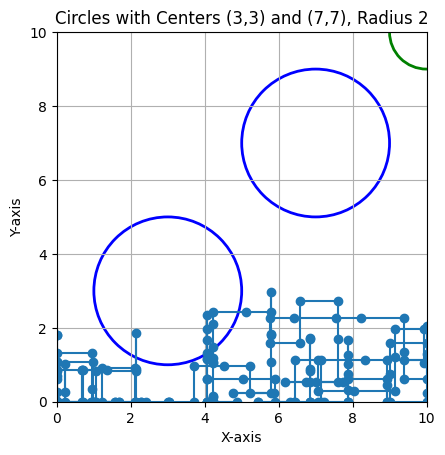

In [67]:
fig, ax = plt.subplots()

# 定义圆的参数
circles = [
    (3, 3, 2),  
    (7, 7, 2),   
    # (10, 10, 1) 
]

# 绘制圆
for x, y, radius in circles:
    circle = plt.Circle((x, y), radius, edgecolor='blue', fill=False, linewidth=2)
    ax.add_patch(circle)

circle = plt.Circle((10, 10), 1, edgecolor='green', fill=False, linewidth=2)
ax.add_patch(circle)

# 设置坐标范围和比例
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')

# 设置标题和坐标轴标签
ax.set_title("Circles with Centers (3,3) and (7,7), Radius 2")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
plt.plot(result_episode[:,0], result_episode[:,1], marker='o', label='y = x^2')
#plt.plot(X_train.reshape(num_episodes*T,2)[:,0], X_train.reshape(num_episodes*T,2)[:,1], 'go')
# 显示图像
plt.grid(True)  # 添加网格
plt.show()

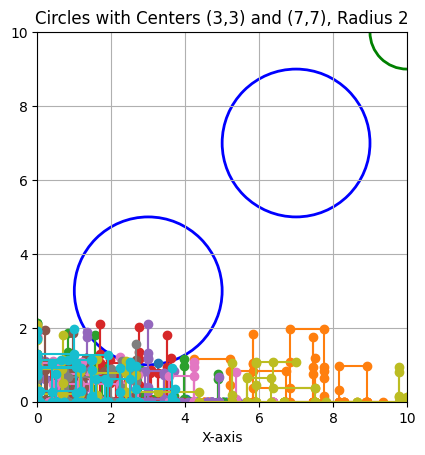

In [68]:
fig, ax = plt.subplots()

# 定义圆的参数
circles = [
    (3, 3, 2),  
    (7, 7, 2),   
    # (10, 10, 1) 
]

# 绘制圆
for x, y, radius in circles:
    circle = plt.Circle((x, y), radius, edgecolor='blue', fill=False, linewidth=2)
    ax.add_patch(circle)

circle = plt.Circle((10, 10), 1, edgecolor='green', fill=False, linewidth=2)
ax.add_patch(circle)

# 设置坐标范围和比例
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')

# 设置标题和坐标轴标签
ax.set_title("Circles with Centers (3,3) and (7,7), Radius 2")
ax.set_xlabel("X-axis")
for i in range(num_multi_rep):
    result_episode=result_safe_route(mu_multi[i],cov_multi[i])
    plt.plot(result_episode[:,0], result_episode[:,1], marker='o', label='y = x^2')
#plt.plot(X_train.reshape(num_episodes*T,2)[:,0], X_train.reshape(num_episodes*T,2)[:,1], 'go')
# 显示图像
plt.grid(True)  # 添加网格
plt.show()